In [50]:
# importing the libraries
import pandas as pd
import numpy as np
import scipy as sp 
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
import os
# suppressing warnings
import warnings
warnings.filterwarnings('ignore')
from statsmodels.stats.outliers_influence import variance_inflation_factor

pd.set_option('display.max_rows', None)

In [51]:
df = pd.read_csv('Documents/Capstone_data/final_merged_data.csv')

In [305]:
cleaned_bicycle_df = pd.read_csv("cleaned_bicycle.csv")

In [306]:
selected_columns = cleaned_bicycle_df.columns.tolist()
selected_columns.append('MAX_SEVERITY_LEVEL')
selected_columns.append('BICYCLE')
selected_columns.append('SIGNALIZED_INT')
filtered_df = df[selected_columns]

In [307]:
bicycle = filtered_df[filtered_df['BICYCLE'] >0]

In [308]:
columns_to_drop = ["BICYCLE", "INJ_SEVERITY"]
bicycle = bicycle.drop(columns=columns_to_drop, errors='ignore')

In [309]:
bicycle['Arrival_Dispach_TM_Diff'] = bicycle['ARRIVAL_TM'] - bicycle['DISPATCH_TM']

In [310]:
bicycle = bicycle.drop(['ICY_ROAD','ILLUMINATION_DARK','WORK_ZONE','COMM_VEH_COUNT','SCH_BUS_IND',
        'SCH_ZONE_IND','INJURY_OR_FATAL','ILLEGAL_DRUG_RELATED',
         'ARRIVAL_TM','DISPATCH_TM','IMPAIRED_DRIVER','COMM_VEHICLE','CRASH_YEAR','VEHICLE_COUNT','ALCOHOL_RELATED','DRUG_RELATED',
        'DRINKING_DRIVER','DRUGGED_DRIVER','YOUNG_DRIVER','AUTOMOBILE_COUNT','HEAVY_TRUCK_COUNT','MARIJUANA_DRUGGED_DRIVER','SMALL_TRUCK_COUNT',
                       'SPEED_LIMIT'], axis = 1)

In [311]:
df_1 = bicycle

In [312]:
# Filter out rows with MAX_SEVERITY_LEVEL with 0 or 9
df_1 = df_1[~df_1['MAX_SEVERITY_LEVEL'].isin([0, 9])]

In [313]:
#convert 1, and 2 to value of 1 showing fatal/serious injury considered as fatal in this case
df_1['Severity_Binary'] = df_1['MAX_SEVERITY_LEVEL'].apply(lambda x: 1 if x in [1, 2] else 0)

In [314]:
df_1 = df_1.drop(['MAX_SEVERITY_LEVEL'], axis = 1)

In [315]:
df_1 = df_1.drop(['BICYCLE_SUSP_SERIOUS_INJ_COUNT'], axis = 1)

In [316]:
df_1.shape

(37021, 64)

In [317]:
df.shape

(4543628, 289)

In [318]:
numerical_var = list(df_1.select_dtypes(exclude = 'object').columns)

categorical_var = list(df_1.select_dtypes(include = 'object').columns)


df_1[numerical_var] = df_1[numerical_var].fillna(df_1[numerical_var].median(), 
                                             inplace = False)

df_1[categorical_var] = df_1[categorical_var].fillna(df_1[categorical_var].mode(), 
                                                 inplace = False)

In [319]:
#convert categorical variables into dummy variables
categorical_var = list(df_1.dtypes[df_1.dtypes == object].index)

dummy_cat_df = pd.get_dummies(df_1[categorical_var], drop_first=True) 

df_1 = df_1.drop(categorical_var, axis = 1) 

df_1 = pd.concat([df_1, dummy_cat_df], axis = 1) 

In [320]:
numeric_columns = df_1.select_dtypes(include='number').columns
X = df_1[numeric_columns]
X = X.drop('Severity_Binary', axis=1)

vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data)

                          Variable        VIF
0                        BUS_COUNT   2.014189
1   CHLDPAS_SUSP_SERIOUS_INJ_COUNT   1.001383
2                   COLLISION_TYPE   2.523835
3                           COUNTY   4.862262
4                      CRASH_MONTH   7.742572
5                      DAY_OF_WEEK   5.310842
6                         DISTRICT   8.363278
7                      HOUR_OF_DAY   5.703136
8                     ILLUMINATION   3.539485
9                   INTERSECT_TYPE   4.171323
10                       PED_COUNT   1.078043
11                    PERSON_COUNT   4.901286
12                  ROAD_CONDITION   2.191522
13                     URBAN_RURAL  20.284389
14                       VAN_COUNT   1.070848
15                        WEATHER1   2.326126
16              AGGRESSIVE_DRIVING   2.296886
17                     ANGLE_CRASH   4.278046
18               BACKUP_CONGESTION   1.022150
19                      CELL_PHONE   1.060336
20                 CHILD_PASSENGER

In [321]:
models = ['LogisticReg', 'DecisionTree', 'RandomForest', 'KNN']

In [322]:
missing_values = df_1.isnull().sum()
missing_values = missing_values[missing_values > 0]
missing_values

Series([], dtype: int64)

In [472]:
input_var = list(set(df_1.columns) - set(['Severity_Binary']))
X = df_1[input_var]
Y = df_1['Severity_Binary']

from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.20, random_state=42)

In [492]:
# Logistic Regression
lr = LogisticRegression(random_state=0, solver='lbfgs',class_weight='balanced') #multi_class='ovr'
lr.fit(X_train, Y_train)

LogisticRegression(class_weight='balanced', random_state=0)

In [557]:
# Decision Trees
dt = DecisionTreeClassifier(criterion = 'gini', splitter='best', max_depth=5)
dt.fit(X_train, Y_train)

DecisionTreeClassifier(max_depth=5)

In [563]:
# Random Forests
rf = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=0,class_weight='balanced')
rf.fit(X_train, Y_train)

RandomForestClassifier(class_weight='balanced', max_depth=5, random_state=0)

In [537]:
# K-NN
knn = KNeighborsClassifier(n_neighbors = 5)
knn.fit(X_train, Y_train)

KNeighborsClassifier()

In [564]:
pred_Y_lr = lr.predict(X_test) # predicts the Y given the fitted model lr

pred_Y_dt = dt.predict(X_test) # predicts the Y given the fitted model dt

pred_Y_rf = rf.predict(X_test) # predicts the Y given the fitted model rf

pred_Y_knn = knn.predict(X_test) # predicts the Y given the fitted model knn

In [565]:
# Logistic Regression
print("Logistic Regression:")
print(classification_report(Y_test, pred_Y_lr))

# Decision Tree
print("\nDecision Tree:")
print(classification_report(Y_test, pred_Y_dt))

# Random Forest
print("\nRandom Forest:")
print(classification_report(Y_test, pred_Y_rf))

# K-Nearest Neighbors
print("\nK-Nearest Neighbors:")
print(classification_report(Y_test, pred_Y_knn))

Logistic Regression:
              precision    recall  f1-score   support

           0       0.91      0.65      0.76      6482
           1       0.18      0.53      0.27       923

    accuracy                           0.64      7405
   macro avg       0.54      0.59      0.51      7405
weighted avg       0.82      0.64      0.70      7405


Decision Tree:
              precision    recall  f1-score   support

           0       0.88      1.00      0.94      6482
           1       0.85      0.09      0.16       923

    accuracy                           0.88      7405
   macro avg       0.87      0.54      0.55      7405
weighted avg       0.88      0.88      0.84      7405


Random Forest:
              precision    recall  f1-score   support

           0       0.93      0.71      0.81      6482
           1       0.24      0.64      0.35       923

    accuracy                           0.70      7405
   macro avg       0.59      0.68      0.58      7405
weighted avg       0.

In [597]:
probabilities = lr.predict_proba(X_test)[:, 1]

# Set a threshold (you can experiment with different threshold values)
threshold = 0.61

# Convert probabilities to binary predictions based on the threshold
pred_Y_lr = (probabilities > threshold).astype(int)
print(classification_report(Y_test, pred_Y_lr))

              precision    recall  f1-score   support

           0       0.89      0.89      0.89      6482
           1       0.21      0.21      0.21       923

    accuracy                           0.80      7405
   macro avg       0.55      0.55      0.55      7405
weighted avg       0.80      0.80      0.80      7405



In [598]:
coefficients = lr.coef_[0]
odds_ratios = np.exp(coefficients)
features_used = X.columns
odds_ratios_df = pd.DataFrame({'Feature': features_used, 'Odds Ratio': odds_ratios})
odds_ratios_df.sort_values(by='Odds Ratio', ascending=False)

,Feature,Odds Ratio
35,ILLUMINATION,1.291161
46,VEH_ROLE,1.099126
41,SEX_M,1.073329
44,DISTRICT,1.058815
5,CURVED_ROAD,1.050806
4,HIT_PARKED_VEHICLE,1.049742
31,LOCAL_ROAD,1.048448
32,LANE_DEPARTURE,1.047643
54,LEFT_TURN,1.045360
37,RUNNING_STOP_SIGN,1.038265


In [595]:
probabilities = lr.predict_proba(X_test)[:, 1]

# Set a threshold (you can experiment with different threshold values)
threshold = 0.879

# Convert probabilities to binary predictions based on the threshold
pred_Y_lr = (probabilities > threshold).astype(int)
print("Logistic Regression:")
print(classification_report(Y_test, pred_Y_lr))

Logistic Regression:
              precision    recall  f1-score   support

           0       0.88      1.00      0.93      6482
           1       1.00      0.00      0.00       923

    accuracy                           0.88      7405
   macro avg       0.94      0.50      0.47      7405
weighted avg       0.89      0.88      0.82      7405



In [596]:
coefficients = lr.coef_[0]
odds_ratios = np.exp(coefficients)
features_used = X.columns
odds_ratios_df = pd.DataFrame({'Feature': features_used, 'Odds Ratio': odds_ratios})
odds_ratios_df.sort_values(by='Odds Ratio', ascending=False)

,Feature,Odds Ratio
35,ILLUMINATION,1.291161
46,VEH_ROLE,1.099126
41,SEX_M,1.073329
44,DISTRICT,1.058815
5,CURVED_ROAD,1.050806
4,HIT_PARKED_VEHICLE,1.049742
31,LOCAL_ROAD,1.048448
32,LANE_DEPARTURE,1.047643
54,LEFT_TURN,1.045360
37,RUNNING_STOP_SIGN,1.038265


In [561]:
from sklearn.metrics import accuracy_score
train_predictions = dt.predict(X_train)
test_predictions = dt.predict(X_test)

# Accuracy on the training set
train_accuracy = accuracy_score(Y_train, train_predictions)
print(f"Training Accuracy: {train_accuracy:.4f}")

# Accuracy on the test set
test_accuracy = accuracy_score(Y_test, test_predictions)
print(f"Test Accuracy: {test_accuracy:.4f}")
if train_accuracy > test_accuracy:
    print("The model may be overfitting, as it performs better on the training set.")
else:
    print("The model generalizes well, as its performance on the test set is comparable to the training set.")


Training Accuracy: 0.8852
Test Accuracy: 0.8843
The model may be overfitting, as it performs better on the training set.


In [593]:
probabilities = rf.predict_proba(X_test)[:, 1]

# Set a threshold (you can experiment with different threshold values)
threshold = 0.609

# Convert probabilities to binary predictions based on the threshold
pred_Y_rf = (probabilities > threshold).astype(int)
print(classification_report(Y_test, pred_Y_rf))

              precision    recall  f1-score   support

           0       0.89      0.99      0.94      6482
           1       0.66      0.17      0.27       923

    accuracy                           0.89      7405
   macro avg       0.78      0.58      0.60      7405
weighted avg       0.86      0.89      0.85      7405



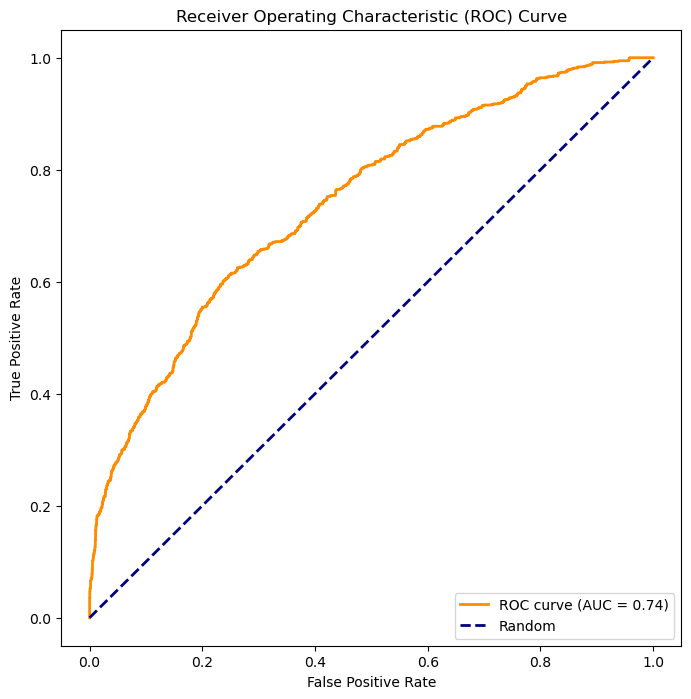

In [587]:
probabilities = rf.predict_proba(X_test)[:, 1]

# Set a threshold
threshold = 0.609

# Convert probabilities to binary predictions based on the threshold
pred_Y_rf = (probabilities > threshold).astype(int)

# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(Y_test, probabilities)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

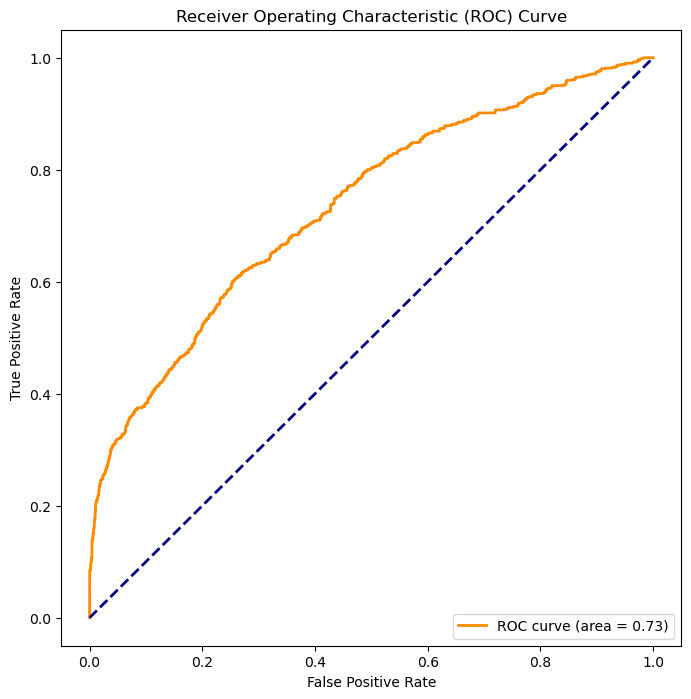

In [546]:
probabilities = rf.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(Y_test, score_Y_dt[:,1])
roc_auc = auc(fpr, tpr)
# Plot the ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [592]:
coefficients = lr.coef_[0]
odds_ratios = np.exp(coefficients)
features_used = X.columns
odds_ratios_df = pd.DataFrame({'Feature': features_used, 'Odds Ratio': odds_ratios})
odds_ratios_df.sort_values(by='Odds Ratio', ascending=False)

,Feature,Odds Ratio
35,ILLUMINATION,1.291161
46,VEH_ROLE,1.099126
41,SEX_M,1.073329
44,DISTRICT,1.058815
5,CURVED_ROAD,1.050806
4,HIT_PARKED_VEHICLE,1.049742
31,LOCAL_ROAD,1.048448
32,LANE_DEPARTURE,1.047643
54,LEFT_TURN,1.045360
37,RUNNING_STOP_SIGN,1.038265


In [252]:
#odds_ratios_df.to_csv('odds_ratios_df.csv')

In [547]:
feature_importances = rf.feature_importances_


for feature, importance in zip(X_train.columns, feature_importances):
    print(f"{feature}: {importance}")

print("\nRandom Forest:")
print(classification_report(Y_test, pred_Y_rf))

SCHOOL_ZONE: 0.00045201603696543426
WORK_ZONE_IND_Y: 0.002967212447288566
BUS_COUNT: 0.0024837743498763356
CURVE_DVR_ERROR: 0.003995939126605636
HIT_PARKED_VEHICLE: 0.03274143522489046
CURVED_ROAD: 0.0075392254150073125
URBAN_RURAL: 0.10869697897584307
COUNTY: 0.10132536760015949
DAY_OF_WEEK: 0.024458103890980073
SIGNALIZED_INT: 0.009194822033917093
PERSON_TYPE: 0.005626963038784293
INTERSECT_TYPE: 0.022009371116860334
ROUNDABOUT: 0.0
CELL_PHONE: 0.0030178918995585097
HIT_POLE: 0.0029319178783324623
SEX_F: 0.0007753941275899332
COLLISION_TYPE: 0.053815099832874635
FATIGUE_ASLEEP: 0.007494415645792446
WET_ROAD: 0.002431775299195514
HIT_EMBANKMENT: 0.0
CROSS_MEDIAN: 0.001076305847405473
WEATHER1: 0.004940561454617343
ROAD_CONDITION: 0.006050225793327598
INTERSECTION: 0.022657600019875695
STOP_CONTROLLED_INT: 0.005924134782040027
BACKUP_CONGESTION: 0.002477051497294504
AGE: 0.026828384638630177
TRAVEL_DIRECTION_U: 0.0008888052587759099
RUNNING_RED_LT: 0.011217295608826257
TRAVEL_DIRECTION

In [548]:
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
feature_importance_df

,Feature,Importance
6,URBAN_RURAL,0.108697
7,COUNTY,0.101325
35,ILLUMINATION,0.071467
44,DISTRICT,0.062476
61,HOUR_OF_DAY,0.055354
16,COLLISION_TYPE,0.053815
33,Arrival_Dispach_TM_Diff,0.049309
32,LANE_DEPARTURE,0.041296
45,PERSON_COUNT,0.040961
4,HIT_PARKED_VEHICLE,0.032741


In [256]:
#feature_importance_df.to_csv("feature_importance_df.csv")

## Can we reproduce with less features

# self note maybe PCA can be added

In [266]:
cleaned_bicycle_df = pd.read_csv("cleaned_bicycle.csv")

In [267]:
selected_columns = cleaned_bicycle_df.columns.tolist()
selected_columns.append('MAX_SEVERITY_LEVEL')
selected_columns.append('BICYCLE')
selected_columns.append('SIGNALIZED_INT')
filtered_df = df[selected_columns]

In [268]:
bicycle = filtered_df[filtered_df['BICYCLE'] >0]

In [269]:
columns_to_drop = ["BICYCLE", "INJ_SEVERITY"]
bicycle = bicycle.drop(columns=columns_to_drop, errors='ignore')

In [270]:
bicycle['Arrival_Dispach_TM_Diff'] = bicycle['ARRIVAL_TM'] - bicycle['DISPATCH_TM']

In [271]:
bicycle = bicycle[['URBAN_RURAL','COUNTY','ILLUMINATION','DISTRICT','HOUR_OF_DAY','COLLISION_TYPE',
'Arrival_Dispach_TM_Diff','LANE_DEPARTURE','PERSON_COUNT','HIT_PARKED_VEHICLE','AGE','DAY_OF_WEEK','INTERSECTION',
'INTERSECT_TYPE','HIT_FIXED_OBJECT','CRASH_MONTH','UNDERAGE_DRNK_DRV','AGGRESSIVE_DRIVING','RESTRAINT_HELMET',
'TAILGATING','IMPACT_POINT','RUNNING_STOP_SIGN','RUNNING_RED_LT','MAX_SEVERITY_LEVEL']]

In [272]:
df_1 = bicycle

In [273]:
# Filter out rows with MAX_SEVERITY_LEVEL with 0 or 9
df_1 = df_1[~df_1['MAX_SEVERITY_LEVEL'].isin([0, 9])]

In [274]:
#convert 1, and 2 to value of 1 showing fatal/serious injury considered as fatal in this case
df_1['Severity_Binary'] = df_1['MAX_SEVERITY_LEVEL'].apply(lambda x: 1 if x in [1, 2] else 0)

In [275]:
df_1 = df_1.drop(['MAX_SEVERITY_LEVEL'], axis = 1)

In [276]:
numerical_var = list(df_1.select_dtypes(exclude = 'object').columns)

categorical_var = list(df_1.select_dtypes(include = 'object').columns)


df_1[numerical_var] = df_1[numerical_var].fillna(df_1[numerical_var].median(), 
                                             inplace = False)

df_1[categorical_var] = df_1[categorical_var].fillna(df_1[categorical_var].mode(), 
                                                 inplace = False)

In [277]:
#convert categorical variables into dummy variables
categorical_var = list(df_1.dtypes[df_1.dtypes == object].index)

dummy_cat_df = pd.get_dummies(df_1[categorical_var], drop_first=True) 

df_1 = df_1.drop(categorical_var, axis = 1) 

df_1 = pd.concat([df_1, dummy_cat_df], axis = 1) 

ValueError: No objects to concatenate

In [278]:
numeric_columns = df_1.select_dtypes(include='number').columns
X = df_1[numeric_columns]
X = X.drop('Severity_Binary', axis=1)

vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data)

                   Variable        VIF
0               URBAN_RURAL  18.603066
1                    COUNTY   4.679852
2              ILLUMINATION   3.334104
3                  DISTRICT   7.987514
4               HOUR_OF_DAY   5.402384
5            COLLISION_TYPE   2.481905
6   Arrival_Dispach_TM_Diff   1.004574
7            LANE_DEPARTURE   1.082881
8              PERSON_COUNT   1.911641
9        HIT_PARKED_VEHICLE   1.043127
10                      AGE   4.234724
11              DAY_OF_WEEK   5.147574
12             INTERSECTION   7.994289
13           INTERSECT_TYPE   3.391576
14         HIT_FIXED_OBJECT   1.010169
15              CRASH_MONTH   7.266125
16        UNDERAGE_DRNK_DRV   1.003894
17       AGGRESSIVE_DRIVING   1.618840
18         RESTRAINT_HELMET   1.488001
19               TAILGATING   1.037473
20             IMPACT_POINT   1.579096
21        RUNNING_STOP_SIGN   1.120584
22           RUNNING_RED_LT   1.074203


In [279]:
models = ['LogisticReg', 'DecisionTree', 'RandomForest', 'KNN']

In [280]:
input_var = list(set(df_1.columns) - set(['Severity_Binary']))
X = df_1[input_var]
Y = df_1['Severity_Binary']

from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.20, random_state=42)

In [303]:
# Logistic Regression
lr = LogisticRegression(random_state=0, solver='lbfgs',class_weight='balanced') #multi_class='ovr'
lr.fit(X_train, Y_train)

LogisticRegression(class_weight='balanced', random_state=0)

In [282]:
# Decision Trees
dt = DecisionTreeClassifier(criterion = 'gini', splitter='best', max_depth=15)
dt.fit(X_train, Y_train)

DecisionTreeClassifier(max_depth=15)

In [300]:
# Random Forests
rf = RandomForestClassifier(n_estimators=200, max_depth=5, random_state=0)
rf.fit(X_train, Y_train)

RandomForestClassifier(max_depth=5, n_estimators=200, random_state=0)

In [297]:
# K-NN
knn = KNeighborsClassifier(n_neighbors = 5)
knn.fit(X_train, Y_train)

KNeighborsClassifier()

In [301]:
pred_Y_lr = lr.predict(X_test) # predicts the Y given the fitted model lr

pred_Y_dt = dt.predict(X_test) # predicts the Y given the fitted model dt

pred_Y_rf = rf.predict(X_test) # predicts the Y given the fitted model rf

pred_Y_knn = knn.predict(X_test) # predicts the Y given the fitted model knn

In [304]:
# Logistic Regression
print("Logistic Regression:")
print(classification_report(Y_test, pred_Y_lr))

# Decision Tree
print("\nDecision Tree:")
print(classification_report(Y_test, pred_Y_dt))

# Random Forest
print("\nRandom Forest:")
print(classification_report(Y_test, pred_Y_rf))

# K-Nearest Neighbors
print("\nK-Nearest Neighbors:")
print(classification_report(Y_test, pred_Y_knn))

Logistic Regression:
              precision    recall  f1-score   support

           0       0.88      1.00      0.93      6482
           1       0.00      0.00      0.00       923

    accuracy                           0.88      7405
   macro avg       0.44      0.50      0.47      7405
weighted avg       0.77      0.88      0.82      7405


Decision Tree:
              precision    recall  f1-score   support

           0       0.95      0.99      0.97      6482
           1       0.93      0.66      0.77       923

    accuracy                           0.95      7405
   macro avg       0.94      0.82      0.87      7405
weighted avg       0.95      0.95      0.95      7405


Random Forest:
              precision    recall  f1-score   support

           0       0.88      1.00      0.93      6482
           1       1.00      0.01      0.02       923

    accuracy                           0.88      7405
   macro avg       0.94      0.50      0.48      7405
weighted avg       0.

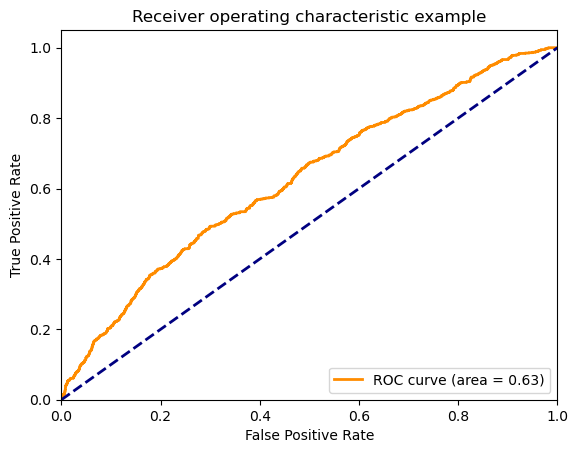

In [287]:
score_Y_dt = lr.predict_proba(X_test)
fpr, tpr, _ = roc_curve(Y_test, score_Y_dt[:,1])
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

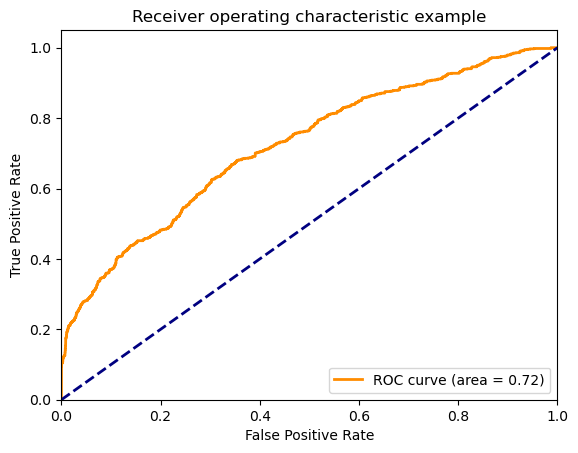

In [288]:
score_Y_dt = rf.predict_proba(X_test)
fpr, tpr, _ = roc_curve(Y_test, score_Y_dt[:,1])
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [289]:
coefficients = lr.coef_[0]
odds_ratios = np.exp(coefficients)
features_used = X.columns
odds_ratios_df = pd.DataFrame({'Feature': features_used, 'Odds Ratio': odds_ratios})
odds_ratios_df.sort_values(by='Odds Ratio', ascending=False)

,Feature,Odds Ratio
19,ILLUMINATION,1.191656
6,HIT_PARKED_VEHICLE,1.036708
16,LANE_DEPARTURE,1.035174
20,RUNNING_STOP_SIGN,1.025851
3,DISTRICT,1.019061
0,HIT_FIXED_OBJECT,1.011724
1,TAILGATING,1.011239
12,RUNNING_RED_LT,1.011075
2,UNDERAGE_DRNK_DRV,1.005262
9,CRASH_MONTH,1.004673


##PART 3

In [480]:
input_var = list(set(df_1.columns) - set(['Severity_Binary']))
X = df_1[input_var]
Y = df_1['Severity_Binary']

from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.20, random_state=42)

In [481]:
# Logistic Regression
lr = LogisticRegression(random_state=0, solver='lbfgs',class_weight='balanced') #multi_class='ovr'
lr.fit(X_train, Y_train)

LogisticRegression(class_weight='balanced', random_state=0)

In [482]:
pred_Y_lr = lr.predict(X_test) # predicts the Y given the fitted model lr

In [483]:
# Logistic Regression
print("Logistic Regression:")
print(classification_report(Y_test, pred_Y_lr))

Logistic Regression:
              precision    recall  f1-score   support

           0       0.91      0.65      0.76      6482
           1       0.18      0.53      0.27       923

    accuracy                           0.64      7405
   macro avg       0.54      0.59      0.51      7405
weighted avg       0.82      0.64      0.70      7405



In [487]:
lr = LogisticRegression(random_state=0, solver='lbfgs', class_weight='balanced', max_iter=1000)

In [490]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report

In [491]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

lr = LogisticRegression(random_state=0, solver='lbfgs', class_weight='balanced', max_iter=1000)

param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],  # Regularization parameter
    'penalty': ['l1', 'l2'],              # Regularization type
}

# Create the GridSearchCV object
grid_search = GridSearchCV(lr, param_grid, cv=5, scoring='f1', n_jobs=-1)


grid_search.fit(X_train_scaled, Y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

# Get the best model
best_lr_model = grid_search.best_estimator_

# Predict using the best model on the scaled test data
pred_Y_lr_tuned_scaled = best_lr_model.predict(X_test_scaled)
print("Tuned Logistic Regression with Scaling:")
print(classification_report(Y_test, pred_Y_lr_tuned_scaled))

Best Hyperparameters: {'C': 10, 'penalty': 'l2'}
Tuned Logistic Regression with Scaling:
              precision    recall  f1-score   support

           0       0.91      0.65      0.76      6482
           1       0.19      0.56      0.28       923

    accuracy                           0.64      7405
   macro avg       0.55      0.61      0.52      7405
weighted avg       0.82      0.64      0.70      7405

